In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.model import (
    rnn_classification_model,
    compile_classification_model,
)
from rna_learn.transform import (
    sequence_embedding, 
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
    normalize, 
    denormalize,
)
from rna_learn.load import load_rna_structure_dataset

In [2]:
seed = 666
np.random.seed(seed)

sns.set(palette='colorblind', font_scale=1.3)

## Model

In [3]:
rna = 'trna'
alphabet = ['.', '(', ')']
alphabet_size = len(alphabet)
metadata_folder = f'data/tab/{rna}.tab'
sequences_folder = 'data/seq/'
classes = ['psychrophile', 'mesophile', 'thermophile', 'hyperthermophile']
n_classes = len(classes)
n_entries_per_class = 153

In [4]:
output_path = os.path.join(os.getcwd(), 'saved_models', f'seed_{seed}', f'{rna}_classification.h5')

model = rnn_classification_model(alphabet_size=alphabet_size, n_classes=n_classes, n_lstm=2)
compile_classification_model(model, learning_rate=1e-4)

model.load_weights(output_path)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, None, 3)]         0         
_________________________________________________________________
masking (Masking)            (None, None, 3)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         41600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404   

## Data Loading

In [5]:
%%time
metadata = pd.read_csv(metadata_folder, delimiter='\t')
metadata['category'] = metadata['temp.cat']

sequences = load_rna_structure_dataset(metadata, sequences_folder)

CPU times: user 204 ms, sys: 150 ms, total: 355 ms
Wall time: 352 ms


In [6]:
def rna_type_distributions(metadata):
    f, axes = plt.subplots(1, 4, figsize=(18, 5))
    axes = axes.flatten()
    for i, rna_type in enumerate(['psychrophile', 'mesophile', 'thermophile', 'hyperthermophile']):
        metadata[metadata['rna.type'] == rna_type]['temp'].hist(ax=axes[i])
        axes[i].set_title(f'{rna_type}');
        axes[i].set_xlim(0, 100)

In [7]:
for i, rna_type in enumerate(['psychrophile', 'mesophile', 'thermophile', 'hyperthermophile']):
    print(rna_type, len(metadata[metadata['rna.type'] == rna_type]))

psychrophile 154
mesophile 4636
thermophile 411
hyperthermophile 306


In [8]:
y_balanced, balanced_metadata = make_dataset_balanced(metadata, n_entries_per_class=n_entries_per_class)

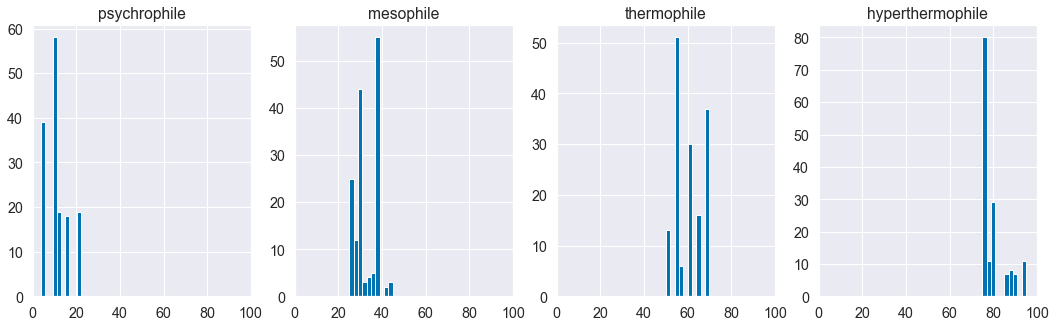

In [9]:
rna_type_distributions(balanced_metadata)

## Evaluation

In [10]:
balanced_sequences = load_rna_structure_dataset(balanced_metadata, sequences_folder)
y = one_hot_encode_classes(y_balanced, classes)
x = sequence_embedding(balanced_sequences, alphabet)
x_train, y_train, x_test, y_test, train_idx, test_idx = split_train_test_set(
    x, y, test_ratio=0.2, return_indices=True)

In [11]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Loss: 1.4008
Accuracy: 0.2869


In [12]:
balanced_metadata

,sp,taxid,temp.cat,rna.type,temp,length,gc,paired,asa,sd.asa,maxmin.asa,mfe,mfe1,mfe2,mfe3,category
0,Aquifex aeolicus,63363,tRNA ala,hyperthermophile,95,73,0.684932,0.493151,172.914479,24.130625,129.8530,-25.4,8.561776,1.152125,6.897895,tRNA ala
1,Caldanaerobacter subterraneus,119072,tRNA ala,hyperthermophile,75,76,0.618421,0.552632,158.407026,17.657989,85.0490,-24.3,5.860808,3.708303,5.423183,tRNA ala
2,Sulfolobus tokodaii,111955,tRNA ala,hyperthermophile,75,74,0.689189,0.621622,166.143526,40.887388,233.2679,-31.6,2.605096,-4.562482,1.349967,tRNA ala
3,Thermoanaerobacter brockii,29325,tRNA ala,hyperthermophile,75,76,0.578947,0.552632,162.027039,21.247820,92.2730,-22.7,5.204949,5.308303,4.767323,tRNA ala
4,Thermocrinis ruber,75906,tRNA ala,hyperthermophile,80,75,0.666667,0.480000,167.370480,25.735351,147.3200,-26.2,6.717969,1.322910,5.871592,tRNA ala
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,Chloroflexus aurantiacus,1108,tRNA val,thermophile,60,77,0.558442,0.675325,171.963557,38.610744,225.3310,-30.6,-3.866926,-2.106304,-3.895800,tRNA val
608,Desulfotomaculum nigrificans,1565,tRNA val,thermophile,55,76,0.631579,0.552632,156.049895,19.691574,85.7900,-28.2,2.712761,-0.191697,2.275136,tRNA val
609,Desulfurobacterium thermolithotrophum,64160,tRNA val,thermophile,70,76,0.631579,0.605263,169.039237,19.443999,100.5390,-33.6,-2.687239,-5.591697,-3.124864,tRNA val
610,Ruminiclostridium thermocellum,1515,tRNA val,thermophile,61,76,0.605263,0.578947,154.653105,17.304454,69.8820,-29.1,0.308855,-1.091697,-0.128770,tRNA val


Evaluation on a set of sequences left out by the balancing of the dataset (i.e. mesophile only):

In [13]:
balanced_set = set([(a, b) for a, b in balanced_metadata[['taxid', 'category']].values])
metadata_other_indices = []
for i, tpl in enumerate(metadata.itertuples()):
    if (tpl.taxid, tpl.category) not in balanced_set:
        metadata_other_indices.append(i)

metadata_other = metadata.iloc[metadata_other_indices].reset_index(drop=True)

In [14]:
other_sequences = load_rna_structure_dataset(metadata_other, sequences_folder)
x_other = sequence_embedding(other_sequences, alphabet)
y_other = one_hot_encode_classes(metadata_other['rna.type'].values, classes)

In [15]:
model.evaluate(x_other, y_other, verbose=0)

[1.4455629208236476, 0.16486211]

## Confusion matrix

In [16]:
y_pred = model(x_test)

labels = [np.argmax(el) for el in y_test]
predictions = [np.argmax(el) for el in y_pred]
conf = tf.math.confusion_matrix(labels, predictions).numpy()
conf

array([[14,  2, 14,  3],
       [10,  6,  9,  7],
       [11,  3, 12,  3],
       [ 6,  7, 12,  3]], dtype=int32)

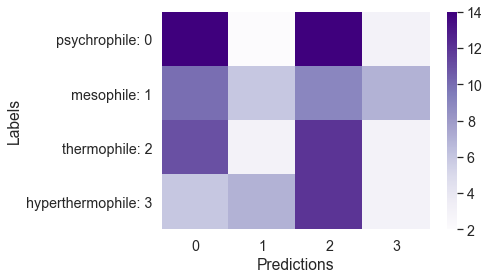

In [17]:
df_cm = pd.DataFrame(
    conf, 
    index=[f'{c}: {i}' for i, c in enumerate(classes)],
    columns=[f'{i}' for i, c in enumerate(classes)],
)
ax = sns.heatmap(df_cm, cmap="Purples");
ax.set_xlabel('Predictions');
ax.set_ylabel('Labels');

In [18]:
conf_sum = np.sum(conf, axis=1)
for i in range(len(classes)):
    acc = 100 * conf[i, i] / conf_sum[i]
    print(f'Accuracy for class {classes[i]}: {acc:.1f}%')

Accuracy for class psychrophile: 42.4%
Accuracy for class mesophile: 18.8%
Accuracy for class thermophile: 41.4%
Accuracy for class hyperthermophile: 10.7%


In [19]:
b = balanced_metadata.iloc[train_idx][['taxid', 'category']]
balanced_set = set([(a, b) for a, b in b.values])
metadata_other_indices = []
for i, tpl in enumerate(balanced_metadata.iloc[test_idx].itertuples()):
    if (tpl.taxid, tpl.category) not in balanced_set:
        metadata_other_indices.append(i)

metadata_other = metadata.iloc[metadata_other_indices].reset_index(drop=True)
other_sequences = load_rna_structure_dataset(metadata_other, sequences_folder)
x_other = sequence_embedding(other_sequences, alphabet)
y_other = one_hot_encode_classes(metadata_other['rna.type'].values, classes)
model.evaluate(x_other, y_other, verbose=0)

[1.4716758180837162, 0.12295082]